In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!pip install ultralytics

from IPython import display
display.clear_output()

!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/107.7 GB disk)


In [4]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.20.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')
from ultralytics import YOLO
import numpy as np

Mounted at /content/drive


In [6]:
MODEL = 'yolov8x.pt'
model =YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 184MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [10]:
SOURCE_VIDEO_PATH = '/content/drive/MyDrive/road_trafifc.mp4'

In [15]:
CLASS_NAMES_DICT = model.model.names
selected_classes = [0,1,2,3,5,7]
selected_classes

[0, 1, 2, 3, 5, 7]


0: 384x640 5 persons, 7 cars, 4 motorcycles, 1 bus, 1 traffic light, 1 bench, 1 backpack, 3451.5ms
Speed: 2.3ms preprocess, 3451.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


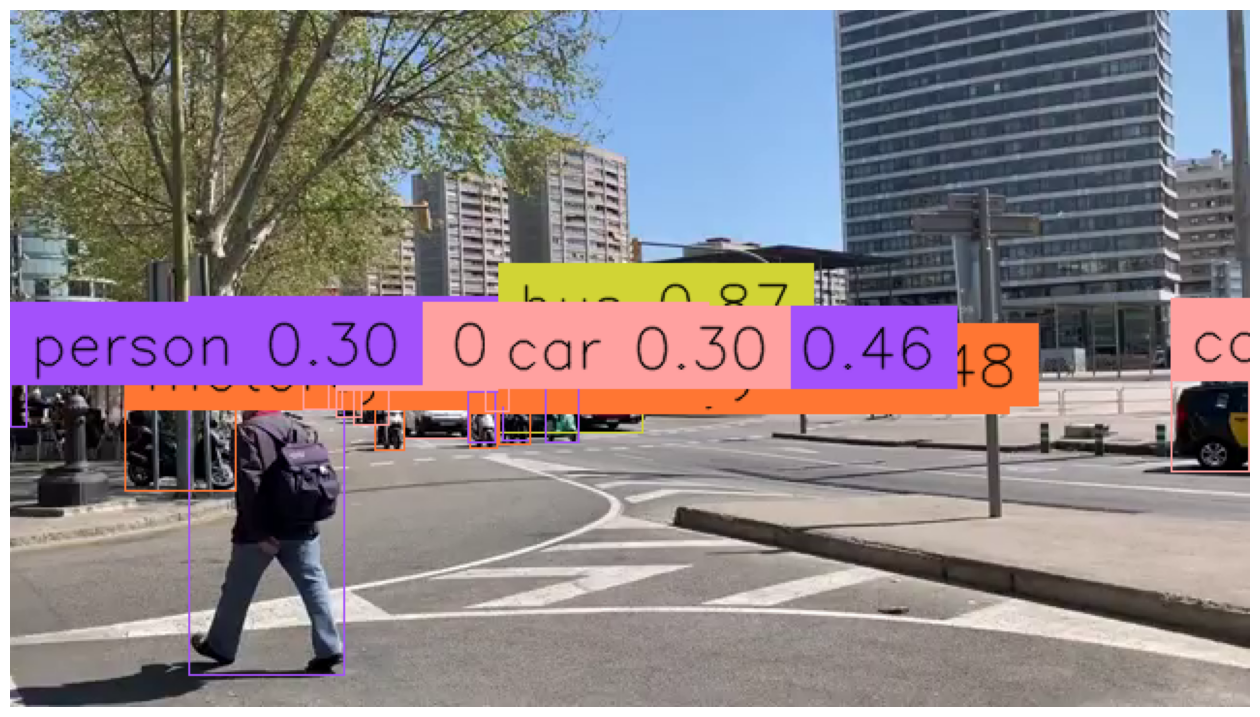

In [16]:
#single frame

generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=1)
iterator =iter(generator)
frame = next(iterator)

results = model(frame)[0]

detections = sv.Detections.from_ultralytics(results)
detections = detections[np.isin(detections.class_id,selected_classes)]
labels = [f'{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}'  for _,_, confidence,class_id,_,_ in detections]
annotated_frame = box_annotator.annotate(scene = frame, detections=detections , labels=labels)
LINE_START =sv.Point(50,1500)
LINE_END =sv.Point(3840-50,1500)

annotated_frame = sv.draw_line(scene = annotated_frame, start = LINE_START, end =LINE_END,color = sv.Color.GREEN, thickness=5)
sv.plot_image(annotated_frame, (16,16))

In [ ]:
# labels = [f'{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}'  for _,_, confidence,class_id,_,_ in detections]
# annotated_frame = box_annotator.annotate(scene = frame, detections=detections , labels=labels)
# LINE_START =sv.Point(50,1500)
# LINE_END =sv.Point(3840-50,1500)

# annotated_frame = sv.draw_line(scene = annotated_frame, start = LINE_START, end =LINE_END,color = sv.Color.GREEN, thickness=5)
# sv.plot_image(annotated_frame, (16,16))

In [17]:
LINE_START =sv.Point(0,1000)
LINE_END =sv.Point(3840-50,1000)
TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"
TARGET_VIDEO_PATH

'/content/vehicle-counting-result-with-counter.mp4'

In [18]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)


VideoInfo(width=640, height=360, fps=29, total_frames=301)

In [19]:
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=29)
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=2, text_scale=0.5)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)
line_zone_annotator = sv.LineZoneAnnotator(thickness=4,text_thickness=2, text_scale=0.5 )

def callback(frame:np.ndarray, index:int) -> np.ndarray:
  results = model(frame, verbose=False)[0]

  detections = sv.Detections.from_ultralytics(results)
  detections = detections[np.isin(detections.class_id,selected_classes)]

  detections = byte_tracker.update_with_detections(detections)

  labels = [f'{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}'  for _,_, confidence,class_id,tracker_id,_ in detections]
  annotated_frame = trace_annotator.annotate(scene=frame.copy(),detections=detections )
  annotated_frame = box_annotator.annotate(scene = annotated_frame, detections=detections , labels=labels)
  line_zone.trigger(detections)
  return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)



sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
Supe

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
